In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def loss_fn(outputs, labels):
    return torch.nn.functional.mse_loss(outputs, labels)

In [6]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    '''Dataset class for loading time series data from a CSV file.'''
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

        # Convert data to numeric, forcing errors to NaN
        self.data[['x', 'y']] = self.data[['x', 'y']].apply(pd.to_numeric, errors='coerce')
        
        # Drop NaN values
        self.data.dropna(inplace=True)
        
        # Ensure the 'time' column is also converted properly if necessary
        self.data['t'] = pd.to_numeric(self.data['t'], errors='coerce')
        self.times = torch.tensor(self.data['t'].values, dtype=torch.float32).view(-1, 1)  # Reshape for single feature input
        self.coords = torch.tensor(self.data[['x', 'y']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        time = self.times[idx]  # Scalar input
        coord = self.coords[idx]  # 2D output
        return time, coord

In [51]:
# Constants
BATCH_SIZE = 20  # Adjust batch size according to your machine's capacity


dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

net = Net()

def loss_fn(outputs, labels):
  #loss
  return torch.nn.functional.mse_loss(outputs, labels)

  
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


In [53]:
for epoch in range(300):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 4.146
[2,    10] loss: 4.904
[3,    10] loss: 4.218
[4,    10] loss: 3.742
[5,    10] loss: 3.354
[6,    10] loss: 3.870
[7,    10] loss: 4.272
[8,    10] loss: 4.015
[9,    10] loss: 3.418
[10,    10] loss: 3.638
[11,    10] loss: 3.501
[12,    10] loss: 4.164
[13,    10] loss: 4.037
[14,    10] loss: 3.744
[15,    10] loss: 3.878
[16,    10] loss: 3.590
[17,    10] loss: 3.638
[18,    10] loss: 3.418
[19,    10] loss: 4.007
[20,    10] loss: 3.619
[21,    10] loss: 3.687
[22,    10] loss: 3.404
[23,    10] loss: 3.984
[24,    10] loss: 3.697
[25,    10] loss: 3.773
[26,    10] loss: 3.490
[27,    10] loss: 3.686
[28,    10] loss: 3.614
[29,    10] loss: 3.862
[30,    10] loss: 3.667
[31,    10] loss: 3.851
[32,    10] loss: 3.661
[33,    10] loss: 3.605
[34,    10] loss: 3.242
[35,    10] loss: 3.817
[36,    10] loss: 4.430
[37,    10] loss: 3.799
[38,    10] loss: 3.093
[39,    10] loss: 3.483
[40,    10] loss: 4.262
[41,    10] loss: 3.661
[42,    10] loss: 3.580
[

<Figure size 1500x700 with 0 Axes>

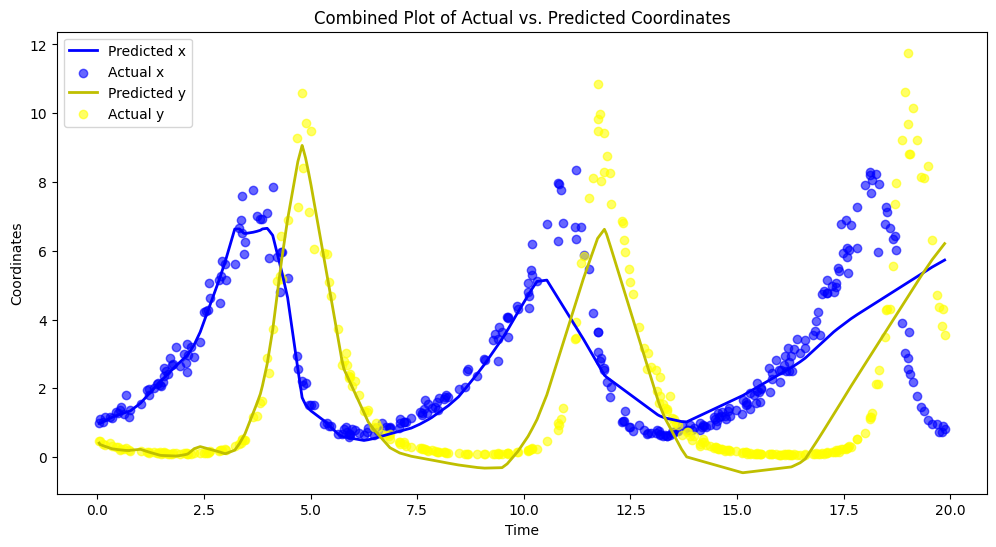

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_results(times, predictions, actuals):
    plt.figure(figsize=(12, 6))

    # Sorting indices for time, to make sure lines are drawn correctly
    sorted_indices = np.argsort(times.squeeze())
    sorted_times = times[sorted_indices].squeeze()
    sorted_predictions = predictions[sorted_indices]
    sorted_actuals = actuals[sorted_indices]

    # Plotting x-values
    plt.plot(sorted_times, sorted_predictions[:, 0], 'b-', label='Predicted x', linewidth=2)  # Predicted x as blue line
    plt.scatter(sorted_times, sorted_actuals[:, 0], color='blue', label='Actual x', alpha=0.6)  # Actual x as blue dots

    # Plotting y-values
    plt.plot(sorted_times, sorted_predictions[:, 1], 'y-', label='Predicted y', linewidth=2)  # Predicted y as yellow line
    plt.scatter(sorted_times, sorted_actuals[:, 1], color='yellow', label='Actual y', alpha=0.6)  # Actual y as yellow dots

    plt.title('Combined Plot of Actual vs. Predicted Coordinates')
    plt.xlabel('Time')
    plt.ylabel('Coordinates')
    plt.legend()
    plt.show()

# Plot results to validate training


# Function to get predictions and actual data
def get_predictions_and_targets(model, data_loader):
    model.eval()  # Set model to evaluation mode
    predictions = []
    actuals = []
    times = []
    with torch.no_grad():  # No need to track gradients
        for time, coords in data_loader:
            outputs = model(time)
            predictions.append(outputs.numpy())
            actuals.append(coords.numpy())
            times.append(time.numpy())

    # Reshape and concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    times = np.concatenate(times, axis=0)
    return times, predictions, actuals

# Get data for plotting
times, predictions, actuals = get_predictions_and_targets(net, trainloader)
plt.figure(figsize=(15, 7))
# Assuming you've obtained times, predictions, actuals from your model and dataset as previously discussed
plot_combined_results(times, predictions, actuals)

In [23]:
import torch.nn as nn
import torch.nn.functional as F
class EnhancedNet(nn.Module):
    def __init__(self):
        super(EnhancedNet, self).__init__()
        self.fc1 = nn.Linear(1, 256)  # Increase the number of neurons
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)  # Dropout layer to prevent overfitting
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 2)  # Output layer predicts x and y values

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

In [24]:
import pandas as pd
import torch
class TimeSeriesDatasetScaled(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.data[['x', 'y']] = self.data[['x', 'y']].apply(pd.to_numeric, errors='coerce')
        self.data.dropna(inplace=True)
        
        # Normalize the 'time' feature to the range [0, 1]
        self.data['t'] = pd.to_numeric(self.data['t'], errors='coerce')
        self.max_time = self.data['t'].max()  # This should ideally be 100 if your data is complete
        self.min_time = self.data['t'].min()
        self.times = torch.tensor((self.data['t'].values - self.min_time) / (self.max_time - self.min_time), dtype=torch.float32).view(-1, 1)
        self.coords = torch.tensor(self.data[['x', 'y']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        time = self.times[idx]  # Normalized scalar input
        coord = self.coords[idx]  # 2D output
        return time, coord

In [55]:
# Constants
BATCH_SIZE = 32  # Adjust batch size according to your machine's capacity

dataset = TimeSeriesDatasetScaled('data.csv')  # Ensure this CSV now potentially includes data up to t = 100
trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


net = EnhancedNet()  # Use the enhanced model

# Continue with optimizer and training setup as before


In [58]:


# Continue with training as before
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
for epoch in range(300):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = torch.nn.functional.mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()
                # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training with Extended Data Range')



[1,    10] loss: 0.972
[2,    10] loss: 1.006
[3,    10] loss: 0.953
[4,    10] loss: 0.942
[5,    10] loss: 0.851
[6,    10] loss: 0.812
[7,    10] loss: 0.842
[8,    10] loss: 0.801
[9,    10] loss: 0.864
[10,    10] loss: 0.865
[11,    10] loss: 0.778
[12,    10] loss: 0.806
[13,    10] loss: 1.085
[14,    10] loss: 0.848
[15,    10] loss: 0.809
[16,    10] loss: 0.755
[17,    10] loss: 0.711
[18,    10] loss: 0.704
[19,    10] loss: 0.690
[20,    10] loss: 0.698
[21,    10] loss: 0.691
[22,    10] loss: 0.670
[23,    10] loss: 0.648
[24,    10] loss: 0.798
[25,    10] loss: 0.706
[26,    10] loss: 0.677
[27,    10] loss: 0.612
[28,    10] loss: 0.600
[29,    10] loss: 0.697
[30,    10] loss: 0.829
[31,    10] loss: 0.820
[32,    10] loss: 0.712
[33,    10] loss: 0.633
[34,    10] loss: 0.583
[35,    10] loss: 0.631
[36,    10] loss: 0.606
[37,    10] loss: 0.586
[38,    10] loss: 0.566
[39,    10] loss: 0.544
[40,    10] loss: 0.598
[41,    10] loss: 0.554
[42,    10] loss: 0.551
[

<Figure size 1500x700 with 0 Axes>

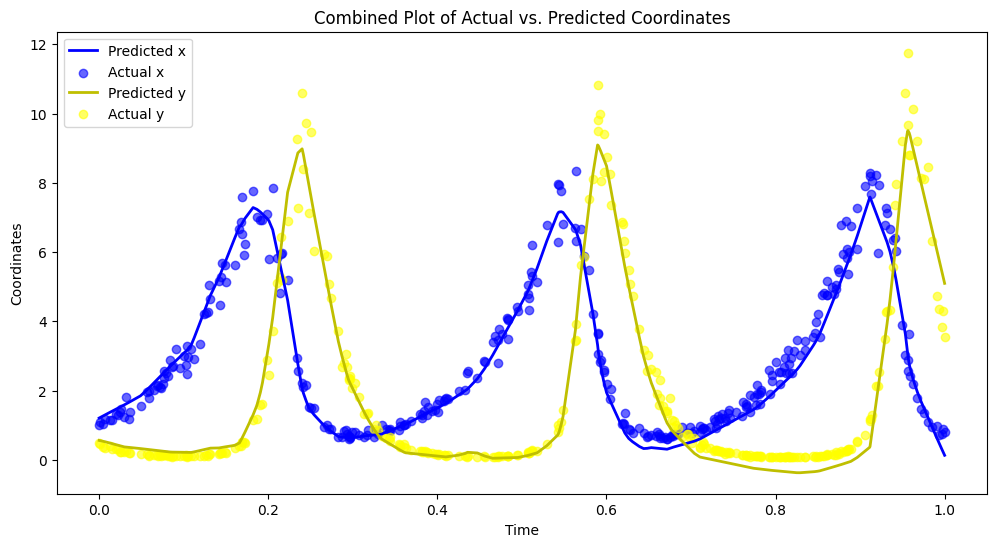

In [59]:
# Get data for plotting
times, predictions, actuals = get_predictions_and_targets(net, trainloader)
plt.figure(figsize=(15, 7))
# Assuming you've obtained times, predictions, actuals from your model and dataset as previously discussed
plot_combined_results(times, predictions, actuals)

Part 3

Please implement the below function min_dist. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the euclidean distance between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at [0.4, 0.3], [0.6, 0.7], resolution 20 pixels.

download (1).png

Case 2: data at [0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2], resolution 256 pixels.

download (2).png

In [75]:
import torch

def min_dist(points, res):
    """
    Calculates a 2D tensor with the minimum distance from each pixel to data.

    Inputs:
        * points: a python list of 2D coordinates, normalized in the range [0,1]
        * res: the resolution of the output tensor.
    Returns:
        A res x res square tensor with floating point values corresponding to the
        euclidean distance to the closest point in points.
    """
    # Convert points list to tensor and scale by resolution
    data_points = torch.tensor(points, dtype=torch.float32) * res

    # Create a grid of coordinates, scaled to the resolution
    y_coords = torch.arange(res).view(res, 1).expand(res, res)
    x_coords = torch.arange(res).view(1, res).expand(res, res)
    
    # Stack coordinates
    grid = torch.stack((x_coords, y_coords), dim=-1)  # Shape: (res, res, 2)

    
    # Reshape grid for broadcasting
    grid = grid.view(res * res, 1, 2)  # Shape: (res * res, 1, 2)
   
    # Expand data points for broadcasting
    data_points = data_points.view(1, -1, 2)  # Shape: (1, num_points, 2)
   
    # Compute distances
    dists = (grid - data_points) ** 2  # (res*res, num_points, 2)
    dists = dists.sum(dim=2)  # sum over x and y coordinate squares
    dists = torch.sqrt(dists)  # (res*res, num_points)

   
    # Get the minimum distance for each location in the grid
    min_dists = dists.min(dim=1)[0]  # min over data points

    # Reshape to the original image shape
    min_dists = min_dists.view(res, res)

    return min_dists

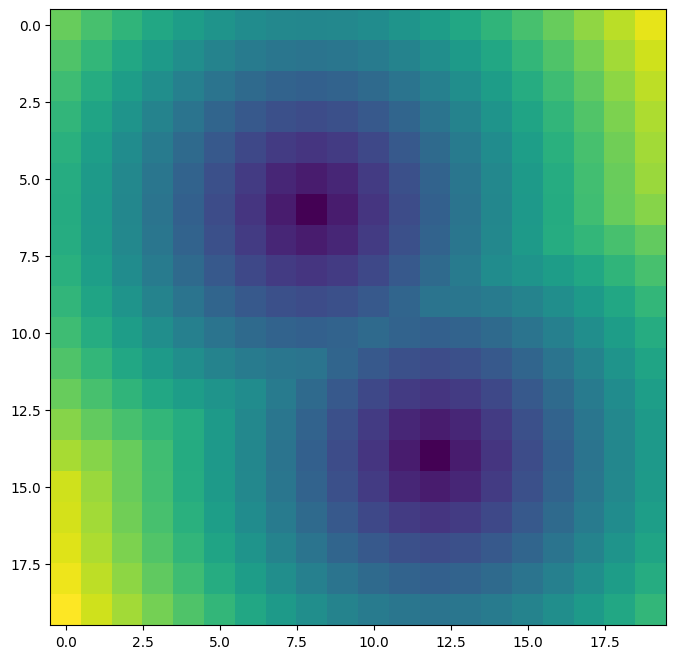

In [76]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

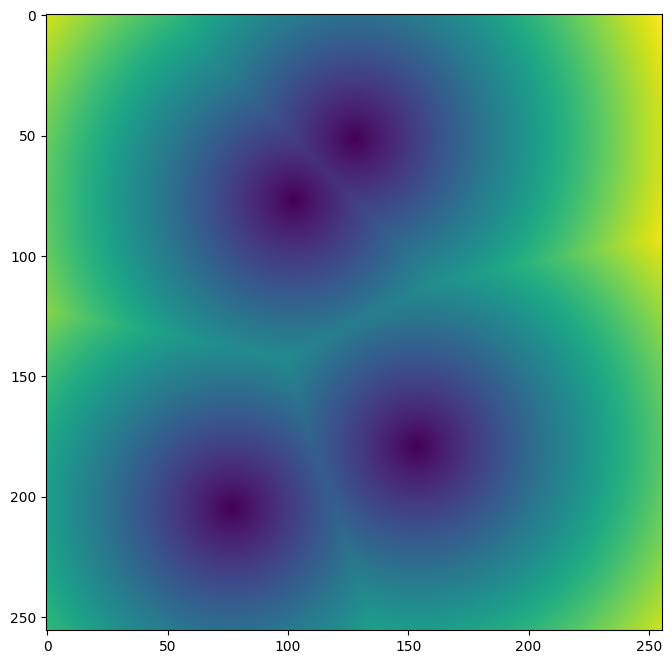

In [62]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

In [73]:
# Python 3 program to demonstrate torch.stack() method 
# for two one dimensional tensors 
# importing torch 
import torch 
  
res = 5  
# creating tensors 
x = torch.tensor([1.,3.,6.,10.]) 
y = torch.tensor([2.,7.,9.,13.]) 
y_coords = torch.arange(res).view(res, 1).expand(res, res)
x_coords = torch.arange(res).view(1, res).expand(res, res)  
# printing above created tensors 
print("Tensor x:", x_coords) 
print("Tensor y:", y_coords) 
  
# join above tensor using "torch.stack()" 
print("join tensors:") 
t = torch.stack((x_coords,y_coords)) 
  
# print final tensor after join 
print(t) 
  
print("join tensors dimension 0:") 
t = torch.stack((x_coords,y_coords), dim = 0) 
print(t) 
  
print("join tensors dimension 1:") 
t = torch.stack((x_coords,y_coords), dim = 1) 
print(t) 

print("join tensors dimension 2:") 

t2= torch.stack((x_coords,y_coords), dim = 2) 
print(t2) 

print("join tensors dimension -1:") 
t3 = torch.stack((x_coords,y_coords), dim = -1) 
print(t3)
t2 == t3 

Tensor x: tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])
Tensor y: tensor([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]])
join tensors:
tensor([[[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]],

        [[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]]])
join tensors dimension 0:
tensor([[[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4],
         [0, 1, 2, 3, 4]],

        [[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]]])
join tensors dimension 1:
tensor([[[0, 1, 2, 3, 4],
         [0, 0, 0, 0, 0]],

        [[0, 1, 2, 3, 4],
         [1, 1, 1, 1, 1]],

        [[0, 1, 2, 3, 4],


tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]]])

In [83]:
import torch

def min_dist(points, res):
    """
    Calculates a batch of 2D tensors with the minimum distance from each pixel to data.

    Inputs:
        points: a tensor of shape [batch_size, num_points, 2] with normalized 2D coordinates in the range [0,1]
        res: the resolution of each output tensor in the batch.
    Returns:
        A tensor of shape [batch_size, res, res] with each element being the Euclidean distance to the closest point in points for that batch.
    """
    batch_size, num_points, _ = points.shape

    # Scale points from [0, 1] range to [0, res - 1]
    scaled_points = points * (res - 1)

    # Create a grid of coordinates, scaled to the resolution
    x_coords = torch.arange(res, device=points.device).view(1, 1, res, 1).expand(batch_size, res, res, 1)
    y_coords = torch.arange(res, device=points.device).view(1, res, 1, 1).expand(batch_size, res, res, 1)
    grid = torch.cat((x_coords, y_coords), dim=-1).float()  # shape [batch_size, res, res, 2]

    # Reshape for broadcasting
    grid = grid.view(batch_size, res * res, 1, 2)  # shape [batch_size, res*res, 1, 2]
    scaled_points = scaled_points.view(batch_size, 1, num_points, 2)  # shape [batch_size, 1, num_points, 2]

    # Compute distances
    dists = (grid - scaled_points) ** 2  # shape [batch_size, res*res, num_points, 2]
    dists = dists.sum(dim=3)  # sum over x and y coordinate squares
    dists = torch.sqrt(dists)  # shape [batch_size, res*res, num_points]

    # Get the minimum distance for each location in the grid
    min_dists = dists.min(dim=2)[0]  # min over data points, shape [batch_size, res*res]

    # Reshape to the original image shape
    min_dists = min_dists.view(batch_size, res, res)

    return min_dists

# Example Usage
batch_size = 3
num_points = 4
res = 100

# Create random points in the range [0,1] with shape [batch_size, num_points, 2]
points = torch.rand(batch_size, num_points, 2)
dist_maps = min_dist(points, res)
print(dist_maps.shape)  # Expected shape: [3, 100, 100]


torch.Size([3, 100, 100])


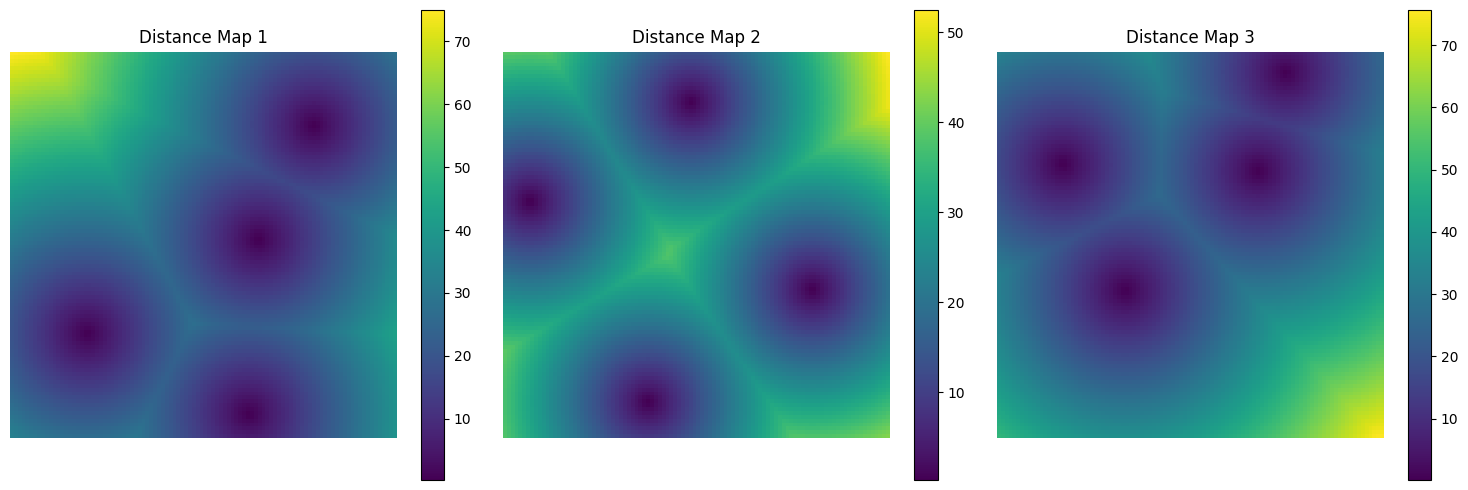

In [84]:
import matplotlib.pyplot as plt

def plot_distance_maps(dist_maps):
    """
    Plots each distance map in a batch.

    Args:
    dist_maps (Tensor): A tensor of shape [batch_size, height, width] where each entry is a distance map.
    """
    batch_size = dist_maps.shape[0]
    fig, axes = plt.subplots(1, batch_size, figsize=(5 * batch_size, 5))
    
    if batch_size == 1:
        axes = [axes]  # Make it iterable if only one subplot

    for i, ax in enumerate(axes):
        # Select the i-th distance map
        distance_map = dist_maps[i].numpy()  # Convert to numpy array for plotting
        img = ax.imshow(distance_map, cmap='viridis', origin='lower')
        ax.set_title(f'Distance Map {i + 1}')
        ax.axis('off')  # Turn off axis labels and ticks
        
        # Optionally add a color bar to each subplot
        fig.colorbar(img, ax=ax)

    plt.tight_layout()
    plt.show()

# Assuming `dist_maps` is your tensor from the `min_dist` function
plot_distance_maps(dist_maps)


In [7]:

import torch

def min_dist(points, res, chunk_size=1024):
    """
    Calculates a batch of 2D tensors with the minimum distance from each pixel to data,
    computed in chunks to handle very large resolutions.

    Inputs:
        points: a tensor of shape [batch_size, num_points, 2] with normalized 2D coordinates in the range [0,1]
        res: the resolution of each output tensor in the batch.
        chunk_size: the size of each chunk to be processed separately (default 1024).
    Returns:
        A tensor of shape [batch_size, res, res] with each element being the Euclidean distance to the closest point in points for that batch.
    """
    batch_size, num_points, _ = points.shape
    # Scale points from [0, 1] range to [0, res - 1]
    scaled_points = points * (res - 1)

    # Initialize the output tensor
    distance_maps = torch.full((batch_size, res, res), float('inf'), device=points.device, dtype=torch.float32)

    # Process the grid in chunks
    for start_row in range(0, res, chunk_size):
        end_row = min(start_row + chunk_size, res)
        for start_col in range(0, res, chunk_size):
            end_col = min(start_col + chunk_size, res)

            # Generate grid chunk
            x_coords = torch.arange(start_col, end_col, device=points.device).view(1, 1, end_col - start_col).expand(batch_size, end_row - start_row, end_col - start_col)
            y_coords = torch.arange(start_row, end_row, device=points.device).view(end_row - start_row, 1).expand(batch_size, end_row - start_row, end_col - start_col)
            grid_chunk = torch.stack((x_coords, y_coords), dim=3).float()  # shape [batch_size, (end_row-start_row), (end_col-start_col), 2]
            
            # Compute distances for the chunk
            grid_chunk = grid_chunk.view(batch_size, (end_row - start_row) * (end_col - start_col), 1, 2)
            points_expanded = scaled_points.view(batch_size, 1, num_points, 2)
            dists_chunk = torch.sqrt(((grid_chunk - points_expanded) ** 2).sum(dim=3))
            min_dists_chunk = dists_chunk.min(dim=2)[0].view(batch_size, end_row - start_row, end_col - start_col)

            # Place computed chunk in the correct position of the full distance map
            distance_maps[:, start_row:end_row, start_col:end_col] = torch.min(distance_maps[:, start_row:end_row, start_col:end_col], min_dists_chunk)

    return distance_maps

# Usage example
batch_size = 3
num_points = 4
res = 16536  # Large resolution example
#res = 100
# Create random points in the range [0,1] with shape [batch_size, num_points, 2]
points = torch.rand(batch_size, num_points, 2, device="mps")
dist_maps = min_dist(points, res, chunk_size=2048)  # Adjust chunk_size based on available memory
print(dist_maps.shape)  # Expected shape: [3, 16536, 16536]

print(points.device)

torch.Size([3, 16536, 16536])
mps:0
